In [1]:
# You need to run this cell to get things setup
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot

import geopandas

import copy

# Lab assignment 4: Doing GIS with `geopandas`

## Grab the data
Three datasets are provided:

+ census population counts for Wellington City from the 2013 Census. These were obtained from [koordinates.com](https://koordinates.com) and from [stats.govt.nz](https://stats.govt.nz)
+ New Zealand road centrelines assembled by [LINZ](https://linz.govt.nz) and served by [koordinates.com](https://koordinates.com)
+ traffic accident data from [NZ Transport Agency](https://nzta.govt.nz/safety/safety-resources/road-safety-information-and-tools/disaggregated-crash-data/)

It is worth pointing out that I did the necessary tidying of raw datasets entirely in `geopandas` to reduce these down to the Wellington City area only, and in the case of the accidents data to focus on 2017 only!

Anyway, here they all are:

In [149]:
pop = geopandas.read_file('data/wgtn-2013-pop.geojson')
rds = geopandas.read_file('data/wgtn-roads.shp')
crashes = geopandas.read_file('data/crashes-2017.geojson')

## Take a look at the data
### First a map
Once again, a reminder of making maps in `geopandas`.

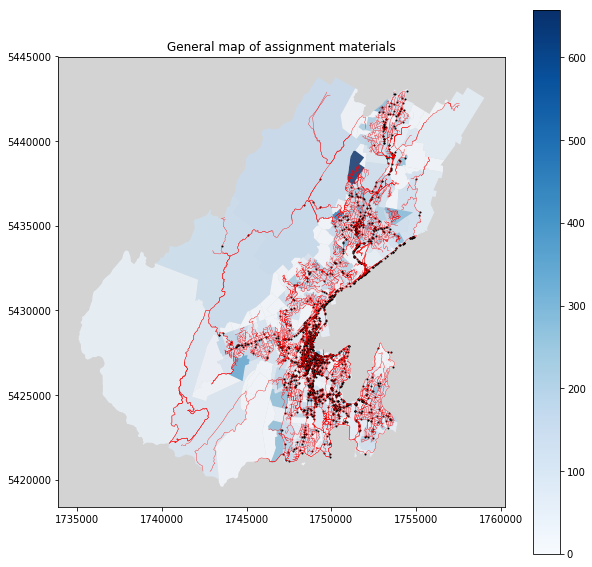

In [128]:
# Make the figure
fig = pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Set background colour to grey
ax.set_facecolor('lightgrey')
ax.set_title("General map of assignment materials")

# Plot meshblock populations
pop.plot(ax=ax, column='pop2013', cmap='Blues', alpha=0.8, legend=True)
# Add the roads
rds.plot(ax=ax, linewidth=0.35, color='r')
# Add the crashes
crashes.plot(ax=ax, color='k', markersize=1)

### Then tables
Also important to examine the data tables, so that you know variable names and so on.

In [129]:
pop.head()

OBJECTID   MB2013  AU2013        AU2013_NAM  pop2013  \
0     30221  1990400  572600      Tawa Central       57   
1     32856  2171003  576400      Newtown East       45   
2     32521  2142900  573400  Mt Victoria West        9   
3     32015  2104000  574702            Wilton      135   
4     32295  2124200  573000           Lambton        3   

                                            geometry  
0  POLYGON ((1752715.1272 5440817.1777, 1752870.7...  
1  POLYGON ((1749094.4798 5424336.6844, 1749100.0...  
2  POLYGON ((1749173.8509 5426375.5898, 1749190.6...  
3  POLYGON ((1747166.1827 5429976.023, 1747153.03...  
4  POLYGON ((1748753.1824 5428642.3022, 1748818.4...

In [130]:
rds.head()

road_secti      length                                           geometry
0     1325758   11.687530  LINESTRING (1748050.91672133 5431494.27297632,...
1     1325784  307.427950  LINESTRING (1751176.549220026 5434024.96273833...
2     1325809  153.915042  LINESTRING (1753310.082238207 5439021.03490052...
3     1325810  157.631564  LINESTRING (1753567.137978687 5438592.38900346...
4     1325811   15.048831  LINESTRING (1753591.558739239 5439033.02053952...

In [131]:
crashes.head()

CRASH_SEV FATAL_COUN SERIOUSINJ MINORINJ_C                 MULTI_VEH  \
0         F          1          0          0  Vehicle(s)+Pedestrian(s)   
1         M          0          0          1            Single vehicle   
2         M          0          0          1  Vehicle(s)+Pedestrian(s)   
3         M          0          0          1            Single vehicle   
4         S          0          1          0            Single vehicle   

    AU_ID    MB_ID     CRASH_LOCN       CRASH_LO_1                 geometry  
0  572600  1990500      MAIN ROAD         ESSEX ST  POINT (1753096 5440813)  
1  573522  2086104  NASSAU AVENUE    JAMAICA DRIVE  POINT (1754055 5438847)  
2  577200  2206200   COBHAM DRIVE  SHELLY BAY ROAD  POINT (1751588 5424742)  
3  573700  2082800      Z CARPARK        GOTHIC ST  POINT (1751402 5434774)  
4  573000  2126900    THE TERRACE  ALLENBY TERRACE  POINT (1748404 5427737)

## The assignment
This assignment challenges you to perform fairly simple GIS data manipulation using `geopandas`.

The output requested a map of traffic accidents per km of road at Census Area Unit level

### Make a census area units dataset

In [157]:
# The population data are in meshblocks, not census area units, 
# but there is an area unit identifier in the pop data set
# so you can use dissolve to make an area unit population dataset
# Hint: set the as_index option to False so that you don't lose
# the AU2013 attribute after the dissove
# Hint: think about what function you need to use to combine the
# populations for meshblocks into area units`
popc = pop.dissolve(by='AU2013', aggfunc='sum', as_index=False)
popc.head()

AU2013                                           geometry  OBJECTID  \
0  569302  POLYGON ((1756675.3829 5438872.8713, 1756728.8...     30889   
1  569402  (POLYGON ((1757824.3233 5440568.8972, 1757994....     58761   
2  569800  (POLYGON ((1755590.472 5434700.4583, 1755592.2...     91250   
3  570700  POLYGON ((1751417.3332 5443117.1128, 1751400.4...     31120   
4  570800  (POLYGON ((1751972.6181 5442011.4729, 1752026....    155577   

   pop2013  
0      234  
1       63  
2       93  
3       12  
4       24

### Spatial join accidents to the census area units

In [133]:
# You might need to experiment a bit here
# You probably need to add a accident_count variable to the crashes dataset
# There are examples in the notebooks of me adding variables to datasets so 
# look at those to see how
# When that's done you will probably want to join crashes to the area units

In [150]:
crashes['number'] = 1
crashes = crashes.dissolve(by="AU_ID", aggfunc='sum', as_index=False)

In [152]:
crash_counts = crashes[['AU_ID', 'number']]

In [158]:
popc = popc.merge(crash_counts, how='left', left_on='AU2013', right_on='AU_ID')

In [161]:
popc.loc[popc.number.isnull(), ['number']] = 0

In [166]:
pc = popc[['AU2013', 'pop2013', 'number', 'geometry']]

In [167]:
pc

AU2013  pop2013  number                                           geometry
0   569302      234     0.0  POLYGON ((1756675.3829 5438872.8713, 1756728.8...
1   569402       63     0.0  (POLYGON ((1757824.3233 5440568.8972, 1757994....
2   569800       93     0.0  (POLYGON ((1755590.472 5434700.4583, 1755592.2...
3   570700       12     0.0  POLYGON ((1751417.3332 5443117.1128, 1751400.4...
4   570800       24     0.0  (POLYGON ((1751972.6181 5442011.4729, 1752026....
5   571000      177     0.0  (POLYGON ((1756130.0995 5442162.0376, 1756127....
6   571200        0     0.0  (POLYGON ((1756752.8654 5442226.3954, 1756730....
7   572500     3567    14.0  POLYGON ((1753444.0431 5439828.7207, 1753390.9...
8   572600     4371    23.0  POLYGON ((1753583.6571 5440422.6034, 1753568.1...
9   572701     3987    20.0  POLYGON ((1754037.1223 5441741.6048, 1754019.1...
10  572702     1578     6.0  POLYGON ((1754106.8383 5440468.546, 1754106.84...
11  572900     4119   128.0  POLYGON ((1749345.0303 5428756.3212, 1749323.2...
12  573000     5622   183.0  POLYGON ((1748334.9599 5427025.7666, 1748299.5...
13  573101     7338   202.0  POLYGON ((1748674.1352 5426648.5806, 1748653.7...
14  573102       36     0.0  (POLYGON ((1749687.129131248 5427509.394400815...
15  573200     3909    25.0  POLYGON ((1748312.1471 5426624.5755, 1748304.6...
16  573300     5106    64.0  POLYGON ((1747975.9485 5425790.5525, 1747976.5...
17  573400     5418    53.0  POLYGON ((1749896.2302 5426298.2862, 1749864.5...
18  573511      348    10.0  POLYGON ((1753243.0409 5437966.8092, 1753207.6...
19  573513     2898     0.0  POLYGON ((1751715.1478 5436698.5975, 1751685.1...
20  573514     3228     0.0  POLYGON ((1750982.8477 5435965.1967, 1750973.4...
21  573522      348    14.0  POLYGON ((1754310.3269 5438498.732, 1754403.17...
22  573523     1245     5.0  POLYGON ((1752574.9072 5436172.0421, 1752396.9...
23  573524      708     2.0  POLYGON ((1754012.7699 5434613.4795, 1754187.7...
24  573525      303     6.0  POLYGON ((1754799.3362 5439953.9597, 1754786.8...
25  573526      177    17.0  POLYGON ((1754359.324 5433983.6725, 1754320.89...
26  573600     1860    10.0  POLYGON ((1751499.9808 5435219.5002, 1751426.3...
27  573700     3738    53.0  POLYGON ((1751223.9888 5434139.8878, 1751225.2...
28  573801     1110     0.0  POLYGON ((1752540.8393 5435787.7227, 1752510.0...
29  573802      966     0.0  POLYGON ((1751895.7329 5434341.3438, 1751895.6...
..     ...      ...     ...                                                ...
58  575800     2208     3.0  POLYGON ((1747921.6894 5423687.1774, 1747892.7...
59  575901     1032     1.0  POLYGON ((1747490.346 5425150.7059, 1747489.84...
60  575902     1746     6.0  POLYGON ((1747772.9544 5422204.4788, 1747769.7...
61  576001     3330    11.0  POLYGON ((1748067.7164 5421379.4233, 1748112.2...
62  576002     3528    11.0  (POLYGON ((1748465.813 5420987.9742, 1748464.6...
63  576100     3549    11.0  POLYGON ((1749992.0696 5422191.0054, 1749992.0...
64  576200     2592    16.0  POLYGON ((1747653.8007 5423700.7984, 1747661.3...
65  576301     3141     0.0  POLYGON ((1749048.0578 5424562.6622, 1749050.2...
66  576302     1008     0.0  POLYGON ((1749004.7108 5424001.7055, 1748994.0...
67  576400     4869    33.0  POLYGON ((1749767.3468 5424377.7976, 1749763.0...
68  576500     1017    39.0  POLYGON ((1749020.6698 5425217.3077, 1748929.5...
69  576600     1056    14.0  POLYGON ((1750367.7839 5427265.8496, 1750368.3...
70  576700     1725    17.0  POLYGON ((1750682.9035 5426813.2358, 1750681.3...
71  576800     4548    17.0  POLYGON ((1750641.409 5425741.4654, 1750632.46...
72  576901     3213    68.0  POLYGON ((1750260.3149 5423828.9956, 1750211.2...
73  576903     3198    44.0  POLYGON ((1750028.9855 5424078.3398, 1749978.1...
74  576904       18     0.0  POLYGON ((1750674.8186 5425090.5628, 1750670.6...
75  577000     3045    28.0  POLYGON ((1751248.045275874 5424632.977060679,...
76  577101      693     0.0  POLYGON ((1752353.945 542

In [171]:
pc.percapita[pc.percapita.isnull()] = 0

/home/osullid3/anaconda3/envs/g425/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [172]:
pc.percapita

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.003925
8     0.005262
9     0.005016
10    0.003802
11    0.031076
12    0.032551
13    0.027528
14    0.000000
15    0.006395
16    0.012534
17    0.009782
18    0.028736
19    0.000000
20    0.000000
21    0.040230
22    0.004016
23    0.002825
24    0.019802
25    0.096045
26    0.005376
27    0.014179
28    0.000000
29    0.000000
        ...   
58    0.001359
59    0.000969
60    0.003436
61    0.003303
62    0.003118
63    0.003099
64    0.006173
65    0.000000
66    0.000000
67    0.006778
68    0.038348
69    0.013258
70    0.009855
71    0.003738
72    0.021164
73    0.013759
74    0.000000
75    0.009195
76    0.000000
77    0.000000
78    0.006421
79    0.000000
80    0.000000
81    0.000000
82    0.004462
83    0.000000
84    0.000000
85    0.010753
86    0.000000
87    0.000000
Name: percapita, Length: 88, dtype: float64

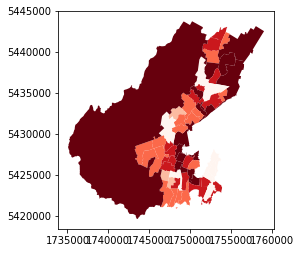

In [175]:
pc.plot(column='percapita', cmap="Reds", scheme='quantiles')

In [178]:
max(pc.percapita)

3.2222222222222223

In [182]:
geopandas.sjoin(rds, popc, op="within").dissolve(by='AU2013', aggfunc='sum', as_index=False)

AU2013                                           geometry  road_secti  \
0   572500  (LINESTRING (1753334.965306334 5438960.8457528...   156268958   
1   572600  (LINESTRING (1753523.558753798 5440112.0362225...   192632096   
2   572701  (LINESTRING (1753788.975583776 5441455.4912240...   148559807   
3   572702  (LINESTRING (1753915.918515851 5440445.9237520...    87888992   
4   572900  (LINESTRING (1748410.557634444 5428564.5645121...   361934627   
5   573000  (LINESTRING (1748197.155016284 5426991.8775178...   368807514   
6   573101  (LINESTRING (1749073.52249901 5426474.11491104...   398914315   
7   573200  (LINESTRING (1748214.563953995 5426418.6670152...   134697469   
8   573300  (LINESTRING (1748738.922878972 5425632.5500278...   153438491   
9   573400  (LINESTRING (1749519.971377074 5426182.6925380...   223160229   
10  573511  (LINESTRING (1751896.610822927 5436701.8750060...    53960275   
11  573513  (LINESTRING (1751418.838099179 5436729.6214315...   183540324   
12  573514  (LINESTRING (1751838.389910241 5435637.1773839...   179495837   
13  573522  (LINESTRING (1753718.011832673 5437426.9832175...    81438033   
14  573523  (LINESTRING (1752685.215609055 5436258.5799271...   144045454   
15  573524  (LINESTRING (1753995.730645208 5434252.8789029...    23300045   
16  573525  (LINESTRING (1753718.190290175 5439200.4514668...    44006010   
17  573526  (LINESTRING (1753070.464075671 5433032.0076651...    28151011   
18  573600  (LINESTRING (1751315.663842702 5435246.9956346...    62253905   
19  573700  (LINESTRING (1751223.988775787 5434139.8877848...   149642333   
20  573801  (LINESTRING (1751796.163964985 5435198.0542553...    57791212   
21  573802  (LINESTRING (1751698.761521637 5434131.2813805...    62280911   
22  573901  (LINESTRING (1752836.042362219 5434994.4447242...    56958458   
23  573902  (LINESTRING (1753523.303366218 5435085.9406095...    82891738   
24  573903  (LINESTRING (1752020.454568679 5434188.0073138...   101425779   
25  574001  (LINESTRING (1751758.081860441 5433366.0029826...   177903270   
26  574002  (LINESTRING (1751950.971165353 5432277.6641723...    31450056   
27  574100  (LINESTRING (1750687.234150094 5433489.6181959...   105771959   
28  574200  (LINESTRING (1749365.239691252 5432016.3013314...    90710657   
29  574302  (LINESTRING (1750054.964908647 5431295.1840912...   155890948   
..     ...                                                ...         ...   
47  575600  (LINESTRING (1747215.611936864 5425449.9677127...   133967931   
48  575701  (LINESTRING (1747507.830514683 5424665.4011885...    61696140   
49  575702  (LINESTRING (1747918.021185476 5424791.7129408...    29352220   
50  575800  (LINESTRING (1747608.423826799 5423387.6287167...    87391079   
51  575901  (LINESTRING (1747440.855384911 5424960.7847523...    28781843   
52  575902  (LINESTRING (1747340.027796933 5421138.1648687...    90546516   
53  576001  (LINESTRING (1747711.384725053 5421078.5805151...    85383272   
54  576002  (LINESTRING (1748785.326326602 5421381.0986966...   121773375   
55  576100  (LINESTRING (1749837.373001903 5421345.2290516...   200628820   
56  576200  (LINESTRING (1748550.768277577 5423658.7447899...    65355055   
57  576301  (LINESTRING (1748925.099055841 5424609.6701543...    85785573   
58  576302  (LINESTRING (1749042.816748942 5423073.7109661...    12573586   
59  576400  (LINESTRING (1749080.36851891 5423126.63266551...   148983325   
60  576500  (LINESTRING (1749299.668929812 5425273.1730968...    31170170   
61  576600  (LINESTRING (1750302.224391507 5427165.2937118...    39836446   
62  576700  (LINESTRING (1751056.097650478 5426919.6289719...   150378636   
63  576800  (LINESTRING (1750395.398516419 5425764.7914774...   155729141   
64  576901  (LINESTRING (1751054.958419763 5423711.5817773...   115373148   
65  576903  (LINESTRING (1750121.506755337 5424088.3211067...    79418454   
66  577000  (LINESTRING (1752029.890972516 5421534.8114524...   177083436   
